## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5000
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCES = [10,25] 

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_acc", 
                          patience=10, 
                          verbose=1
                          )

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for PATIENCE in PATIENCES:
    earlystop = EarlyStopping(monitor="val_acc", 
                          patience=PATIENCE, 
                          verbose=1
                          )
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print('PATIENCE:', PATIENCE)
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    results['pat'+str(PATIENCE)] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

W0426 03:31:45.595499  3412 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0426 03:31:45.596499  3412 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0426 03:31:45.607499  3412 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0426 03:31:45.608501  3412 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0426 03:31:45.610496  3412 deprecation_wrapper.py:119] From D:\Anaconda3\li

PATIENCE: 10


W0426 03:31:45.850527  3412 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0426 03:31:45.932527  3412 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5000
50000/50000 [==============================] - 2s 42us/step - loss: 2.1904 - acc: 0.2728 - val_loss: 2.1280 - val_acc: 0.3066
Epoch 2/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.7406 - acc: 0.3938 - val_loss: 1.7869 - val_acc: 0.3752
Epoch 3/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.6158 - acc: 0.4370 - val_loss: 1.7007 - val_acc: 0.4092
Epoch 4/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.5442 - acc: 0.4607 - val_loss: 1.6393 - val_acc: 0.4241
Epoch 5/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.4883 - acc: 0.4788 - val_loss: 1.6041 - val_acc: 0.4382
Epoch 6/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.4409 - acc: 0.4956 - val_loss: 1.5649 - val_acc: 0.4512
Epoch 7/5000
50000/50000 [==============================] - 2s 32us/step - loss: 1.4024 - acc: 0.5087 - val_loss: 1.

50000/50000 [==============================] - 2s 31us/step - loss: 0.3641 - acc: 0.9125 - val_loss: 1.7948 - val_acc: 0.4865
Epoch 60/5000
50000/50000 [==============================] - 2s 31us/step - loss: 0.3546 - acc: 0.9155 - val_loss: 1.8249 - val_acc: 0.4821
Epoch 61/5000
50000/50000 [==============================] - 2s 31us/step - loss: 0.3393 - acc: 0.9217 - val_loss: 1.8595 - val_acc: 0.4809
Epoch 62/5000
50000/50000 [==============================] - 2s 31us/step - loss: 0.3261 - acc: 0.9267 - val_loss: 1.8618 - val_acc: 0.4835
Epoch 63/5000
50000/50000 [==============================] - 2s 31us/step - loss: 0.3146 - acc: 0.9306 - val_loss: 1.8802 - val_acc: 0.4828
Epoch 00063: early stopping


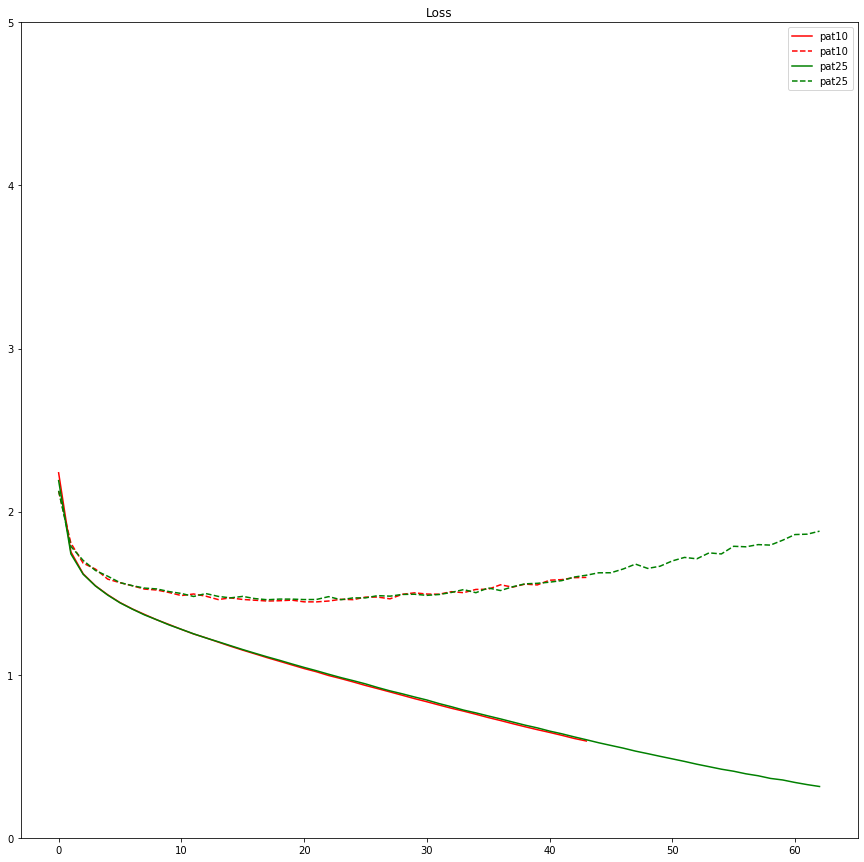

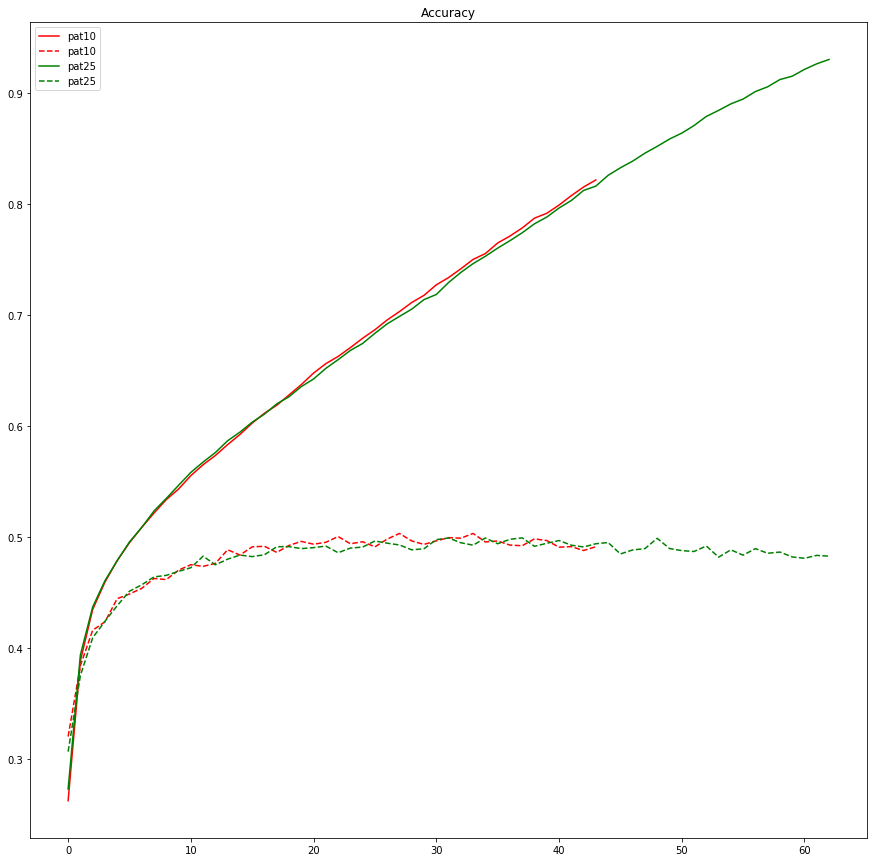

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c", "w"]

plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()